In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import VGG16
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

# Read directory location

In [5]:
'''from google.colab import drive
drive.mount('/content/drive')
maindr='/content/drive/MyDrive'''

maindr="D:/"
datadr=os.path.join(maindr,"Plant_Types_Identification")
alldata=os.listdir(datadr)
alldata

['Data-1', 'Data-2']

## Preparing Augmentation Process and Necessary Parameters

In [82]:
perfd1=[[],[],[],[]]
perfd2=[[],[],[],[]]
img_h = 80
img_w = 80
bs=64
epoc=10

datagen = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)

## Configuring DenseNet

In [44]:
def config_densenet(n):
    densenet = DenseNet121(weights='imagenet', include_top=False)
    input = Input(shape=(img_h, img_w, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(n,activation = 'softmax', name='root')(x)
    densemodel = Model(input,output)
    densemodel.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    densemodel.summary()
    return densemodel

## Configuring VGG

In [45]:
def config_vgg(n):
    vgg = VGG16(weights='imagenet', include_top=False)
    input = Input(shape=(img_h, img_w, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = vgg(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(n,activation = 'softmax', name='root')(x)
    vggmodel = Model(input,output)
    vggmodel.compile(loss='categorical_crossentropy',  metrics=['accuracy'])
    vggmodel.summary()
    return vggmodel

## Configuring Xception

In [75]:
def config_xception(n):
    xcp = Xception(weights='imagenet', include_top=False)
    input = Input(shape=(img_h, img_w, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = xcp(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(n,activation = 'softmax', name='root')(x)
    xcpmodel = Model(input,output)
    xcpmodel.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    xcpmodel.summary()
    return xcpmodel

# Plant Detection using Data-1

## Preparting Data-1

In [47]:
dr1=os.path.join(datadr,alldata[0])
data1lbl=os.listdir(os.path.join(datadr,alldata[0]))
data1lbl

['Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Peach',
 'Pepper',
 'Potato',
 'Raspberry',
 'Soybean',
 'Strawberry',
 'Tomato']

In [48]:
tot=0
for i in data1lbl:
    presdir=os.path.join(dr1 ,i)
    print("{}  contains {} image files.".format(i,len(os.listdir(presdir))))
    tot+=len(os.listdir(presdir))
print("\nTotal images in the database: ",tot)

Apple  contains 1316 image files.
Blueberry  contains 1202 image files.
Cherry  contains 684 image files.
Corn  contains 930 image files.
Grape  contains 339 image files.
Peach  contains 288 image files.
Pepper  contains 1183 image files.
Potato  contains 122 image files.
Raspberry  contains 297 image files.
Soybean  contains 4072 image files.
Strawberry  contains 365 image files.
Tomato  contains 1273 image files.

Total images in the database:  12071


In [49]:
trd = []
for pid, sp in enumerate(data1lbl):
    for file in os.listdir(os.path.join(dr1, sp)):
        trd.append(['{}/{}'.format(sp, file), pid, sp])
        
train1 = pd.DataFrame(trd, columns=['Filename', 'Plant Label','Plant Name']).sample(frac=1).reset_index(drop=True)
train1.head()

,Filename,Plant Label,Plant Name
0,Tomato/e1436a17-dca7-4687-a0ec-31a28389063e___...,11,Tomato
1,Soybean/931b78e0-97b2-408f-85c0-ee5af34dec1b__...,9,Soybean
2,Corn/21f7da6b-c22e-4f1a-9a22-39aaaa6cc38a___R....,3,Corn
3,Blueberry/ffb7e91e-f8af-403b-9ea0-ff5c6c406102...,1,Blueberry
4,Apple/e181a90b-4e75-418b-a8d8-98173cd8bd1a___R...,0,Apple


## Preprocesing Data-1

In [50]:
def processing(location):
    return cv2.imread(os.path.join(dr1, location))
def croppinge(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train1 = np.zeros((train1.shape[0], img_h, img_w, 3))
for i, file in tqdm(enumerate(train1['Filename'].values)):
    image = processing(file)
    if image is not None:
        X_train1[i] = croppinge(image, (img_h, img_w))
X_train1 = X_train1 / 255.
print('train1 Shape: {}'.format(X_train1.shape))

Y_train1 = train1['Plant Label'].values
Y_train1 = to_categorical(Y_train1, num_classes=len(data1lbl))

X_train1, X_val1, Y_train1, Y_val1 = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=32)

12071it [00:22, 530.43it/s]


train1 Shape: (12071, 80, 80, 3)


In [51]:
datagen.fit(X_train1)

## Training with DenseNet for Data-1

In [52]:
densemodel=config_densenet(len(data1lbl))
densemodelhist = densemodel.fit_generator(datagen.flow(X_train1, Y_train1, batch_size=bs),
               steps_per_epoch= X_train1.shape[0] //bs,
               epochs=epoc,
               verbose=2,
               validation_data=(X_val1, Y_val1))
#X_train1.shape[0] //bs,

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_7   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_14 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0   

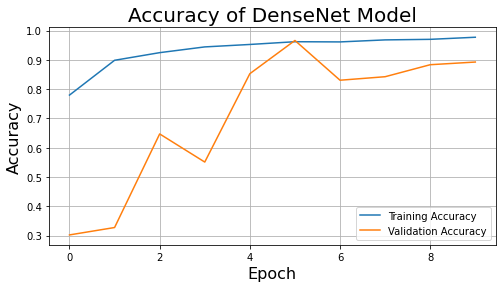

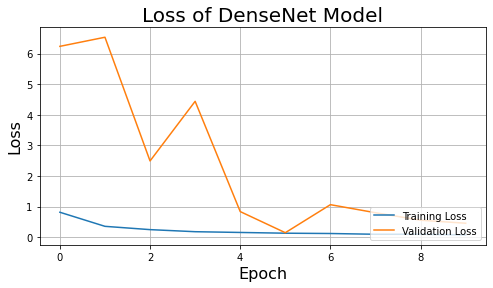

In [40]:
mtr=["Accuracy","Loss"]
for i in mtr:
  plt.figure(figsize=(8,4))
  plt.title("{} of DenseNet Model".format(i),fontsize=20)
  plt.plot(densemodelhist.history['{}'.format(i.lower())],label="Training {}".format(i))
  plt.plot(densemodelhist.history['{}'.format("val_"+i.lower())],label="Validation {}".format(i))
  plt.xlabel("Epoch",fontsize=16)
  plt.ylabel("{}".format(i),fontsize=16)
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()

In [83]:
denloss, denacc = densemodel.evaluate(X_val1, Y_val1)
denlossT, denaccT = densemodel.evaluate(X_train1, Y_train1)
print('Final Loss in Testing: {}, Final Accuracy in Testing: {}%'.format(denloss, round(denacc,4)*100))
print('Final Loss in Training: {}, Final Accuracy in Training: {}%'.format(denlossT, round(denaccT,4)*100))
perfd1[0].append(round(denacc,4)*100)
perfd1[1].append(round(denaccT,4)*100)
perfd1[2].append(round(denloss,3))
perfd1[3].append(round(denlossT,3))

302/302 [==============================] - 86s 284ms/step - loss: 0.1955 - accuracy: 0.9496
Final Loss in Testing: 0.20196641981601715, Final Accuracy in Testing: 95.16%
Final Loss in Training: 0.19552932679653168, Final Accuracy in Training: 94.96%


## Training with VGG for Data-1

In [53]:
vggmodel=config_vgg(len(data1lbl))
vggmodellhist = vggmodel.fit_generator(datagen.flow(X_train1, Y_train1, batch_size=bs),
               steps_per_epoch=X_train1.shape[0] //bs,
               epochs=epoc,
               verbose=2,
               validation_data=(X_val1, Y_val1))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 80, 80, 3)         84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_16 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 512)               0   

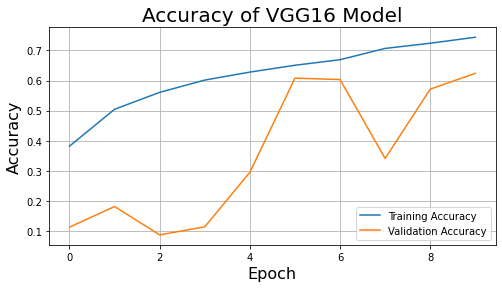

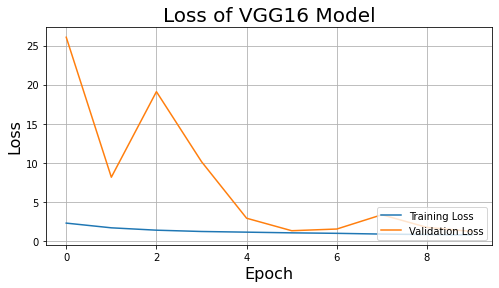

302/302 [==============================] - 139s 459ms/step - loss: 1.2398 - accuracy: 0.6050
Final Loss in Testing: 1.2073861360549927, Final Accuracy in Testing: 62.4%
Final Loss in Training: 1.2397643327713013, Final Accuracy in Training: 60.5%


In [84]:
for i in mtr:
  plt.figure(figsize=(8,4))
  plt.title("{} of VGG16 Model".format(i),fontsize=20)
  plt.plot(vggmodellhist.history['{}'.format(i.lower())],label="Training {}".format(i))
  plt.plot(vggmodellhist.history['{}'.format("val_"+i.lower())],label="Validation {}".format(i))
  plt.xlabel("Epoch",fontsize=16)
  plt.ylabel("{}".format(i),fontsize=16)
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()

vggloss, vggacc = vggmodel.evaluate(X_val1, Y_val1)
vgglossT, vggaccT = vggmodel.evaluate(X_train1, Y_train1)
print('Final Loss in Testing: {}, Final Accuracy in Testing: {}%'.format(vggloss, round(vggacc,4)*100))
print('Final Loss in Training: {}, Final Accuracy in Training: {}%'.format(vgglossT, round(vggaccT,4)*100))
perfd1[0].append(round(vggacc,4)*100)
perfd1[1].append(round(vggaccT,4)*100)
perfd1[2].append(round(vggloss,3))
perfd1[3].append(round(vgglossT,3))

## Training with Xception for Data-1

In [56]:
xcpmodel=config_xception(len(data1lbl))
xcpmodellhist = xcpmodel.fit_generator(datagen.flow(X_train1, Y_train1, batch_size=bs),
               steps_per_epoch=X_train1.shape[0] //bs,
               epochs=epoc,
               verbose=2,
               validation_data=(X_val1, Y_val1))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 80, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_22 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 2048)              0   

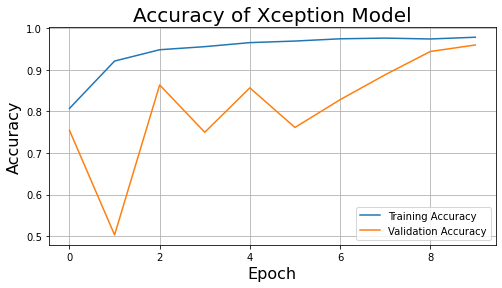

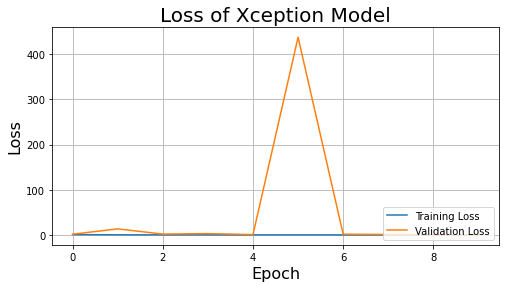

302/302 [==============================] - 58s 193ms/step - loss: 0.1271 - accuracy: 0.9683
Final Loss in Testing: 0.1661173403263092, Final Accuracy in Testing: 95.98%
Final Loss in Training: 0.12706004083156586, Final Accuracy in Training: 96.83%


In [85]:
for i in mtr:
  plt.figure(figsize=(8,4))
  plt.title("{} of Xception Model".format(i),fontsize=20)
  plt.plot(xcpmodellhist.history['{}'.format(i.lower())],label="Training {}".format(i))
  plt.plot(xcpmodellhist.history['{}'.format("val_"+i.lower())],label="Validation {}".format(i))
  plt.xlabel("Epoch",fontsize=16)
  plt.ylabel("{}".format(i),fontsize=16)
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
xcploss, xcpacc = xcpmodel.evaluate(X_val1, Y_val1)
xcplossT, xcpaccT = xcpmodel.evaluate(X_train1, Y_train1)
print('Final Loss in Testing: {}, Final Accuracy in Testing: {}%'.format(xcploss, round(xcpacc,4)*100))
print('Final Loss in Training: {}, Final Accuracy in Training: {}%'.format(xcplossT, round(xcpaccT,4)*100))
perfd1[0].append(round(xcpacc,4)*100)
perfd1[1].append(round(xcpaccT,4)*100)
perfd1[2].append(round(xcploss,3))
perfd1[3].append(round(xcplossT,3))

In [59]:
densemodel.save('densemodel_1.h5')
vggmodel.save('vggmodel_1.h5')
xcpmodel.save('xcpmodel_1.h5')

## Preparing Data-2

In [60]:
dr2=os.path.join(datadr,alldata[1])
data2lbl=os.listdir(os.path.join(datadr,alldata[1]))
data2lbl

['Pepper', 'Potato', 'Tomato']

In [61]:
tot1=0
for i in data2lbl:
    presdir1=os.path.join(dr1 ,i)
    print("{}  contains {} image files.".format(i,len(os.listdir(presdir1))))
    tot1+=len(os.listdir(presdir1))
print("\nTotal images in the database: ",tot1)

Pepper  contains 1183 image files.
Potato  contains 122 image files.
Tomato  contains 1273 image files.

Total images in the database:  2578


In [62]:
trd1 = []
for pid1, sp1 in enumerate(data2lbl):
    for file1 in os.listdir(os.path.join(dr2, sp1)):
        trd1.append(['{}/{}'.format(sp1, file1), pid1, sp1])
        
train2 = pd.DataFrame(trd1, columns=['Filename', 'Plant Label','Plant Name']).sample(frac=1).reset_index(drop=True)
train2.head()

,Filename,Plant Label,Plant Name
0,Tomato/8ac1645d-48d9-4f3e-842b-0187daeeb57c___...,2,Tomato
1,Tomato/534e4d2c-e2cc-4448-9181-95b9af3ff56a___...,2,Tomato
2,Pepper/a04d1272-dcb1-4c5a-8dcd-cd93b4e73d96___...,0,Pepper
3,Tomato/0a86ddc0-4950-4efc-9260-0f16d4db046b___...,2,Tomato
4,Pepper/9cefa2ea-236f-442b-85d1-7bdd7e651039___...,0,Pepper


## Preprocessing Data-2

In [64]:
X_train2 = np.zeros((train2.shape[0], img_h, img_w, 3))
for i1, file1 in tqdm(enumerate(train2['Filename'].values)):
    image1 = processing(file1)
    if image1 is not None:
        X_train2[i1] = croppinge(image1, (img_h, img_w))
X_train2 = X_train2 / 255.
print('train1 Shape: {}'.format(X_train2.shape))

Y_train2 = train2['Plant Label'].values
Y_train2 = to_categorical(Y_train2, num_classes=len(data2lbl))

X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train2, Y_train2, test_size=0.2, random_state=32)

3221it [00:06, 506.76it/s]


train1 Shape: (3221, 80, 80, 3)


In [66]:
datagen2 = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)
datagen2.fit(X_train2)

## Training DendseNet Model with Data-2

In [67]:
densemodel2=config_densenet(len(data2lbl))
densemodelhist2 = densemodel2.fit_generator(datagen2.flow(X_train2, Y_train2, batch_size=bs),
               steps_per_epoch= X_train2.shape[0] //bs,
               epochs=epoc,
               verbose=2,
               validation_data=(X_val2, Y_val2))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 80, 80, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_10  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_24 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0  

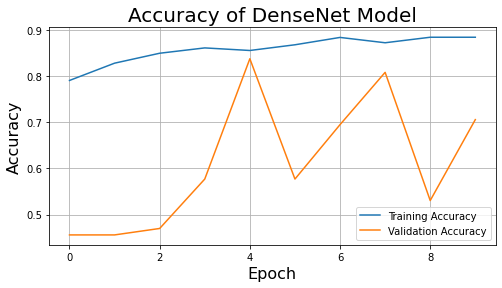

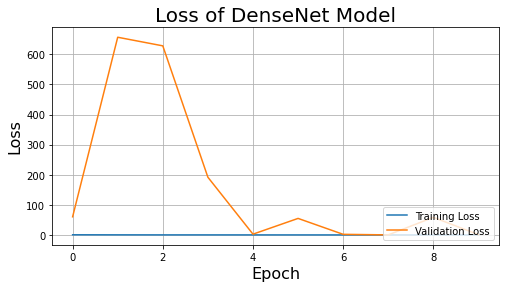

81/81 [==============================] - 23s 284ms/step - loss: 1.3084 - accuracy: 0.6638
Final Loss in Testing: 1.162845492362976, Final Accuracy in Testing: 70.54%
Final Loss in Training: 1.3083988428115845, Final Accuracy in Training: 66.38%


In [86]:
mtr=["Accuracy","Loss"]
for i in mtr:
  plt.figure(figsize=(8,4))
  plt.title("{} of DenseNet Model".format(i),fontsize=20)
  plt.plot(densemodelhist2.history['{}'.format(i.lower())],label="Training {}".format(i))
  plt.plot(densemodelhist2.history['{}'.format("val_"+i.lower())],label="Validation {}".format(i))
  plt.xlabel("Epoch",fontsize=16)
  plt.ylabel("{}".format(i),fontsize=16)
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
denloss2, denacc2 = densemodel2.evaluate(X_val2, Y_val2)
denloss2T, denacc2T = densemodel2.evaluate(X_train2, Y_train2)
print('Final Loss in Testing: {}, Final Accuracy in Testing: {}%'.format(denloss2, round(denacc2,4)*100))
print('Final Loss in Training: {}, Final Accuracy in Training: {}%'.format(denloss2T, round(denacc2T,4)*100))
perfd2[0].append(round(denacc2,4)*100)
perfd2[1].append(round(denacc2T,4)*100)
perfd2[2].append(round(denloss2,3))
perfd2[3].append(round(denloss2T,3))

## Training VGG Model with Data-2

In [69]:
vggmodel2=config_vgg(len(data2lbl))
vggmodelhist2 = vggmodel2.fit_generator(datagen2.flow(X_train2, Y_train2, batch_size=bs),
               steps_per_epoch= X_train2.shape[0] //bs,
               epochs=epoc,
               verbose=2,
               validation_data=(X_val2, Y_val2))

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 80, 80, 3)         84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_11  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 512)               0  

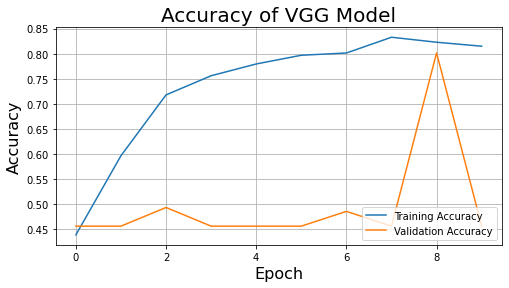

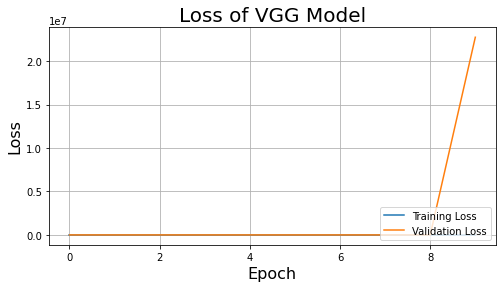

81/81 [==============================] - 38s 466ms/step - loss: 23207364.0000 - accuracy: 0.4596
Final Loss in Testing: 22742722.0, Final Accuracy in Testing: 45.58%
Final Loss in Training: 23207364.0, Final Accuracy in Training: 45.96%


In [87]:
mtr=["Accuracy","Loss"]
for i in mtr:
  plt.figure(figsize=(8,4))
  plt.title("{} of VGG Model".format(i),fontsize=20)
  plt.plot(vggmodelhist2.history['{}'.format(i.lower())],label="Training {}".format(i))
  plt.plot(vggmodelhist2.history['{}'.format("val_"+i.lower())],label="Validation {}".format(i))
  plt.xlabel("Epoch",fontsize=16)
  plt.ylabel("{}".format(i),fontsize=16)
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
vggloss2, vggacc2 = vggmodel2.evaluate(X_val2, Y_val2)
vggloss2T, vggacc2T = vggmodel2.evaluate(X_train2, Y_train2)
print('Final Loss in Testing: {}, Final Accuracy in Testing: {}%'.format(vggloss2, round(vggacc2,4)*100))
print('Final Loss in Training: {}, Final Accuracy in Training: {}%'.format(vggloss2T, round(vggacc2T,4)*100))
perfd2[0].append(round(vggacc2,4)*100)
perfd2[1].append(round(vggacc2T,4)*100)
perfd2[2].append(round(vggloss2,3))
perfd2[3].append(round(vggloss2T,3))

## Training Xception Model with Data-2

In [77]:
xcpmodel2=config_xception(len(data2lbl))
xcpmodelhist2 = xcpmodel2.fit_generator(datagen2.flow(X_train2, Y_train2, batch_size=bs),
               steps_per_epoch= X_train2.shape[0] //bs,
               epochs=epoc,
               verbose=2,
               validation_data=(X_val2, Y_val2))

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 80, 80, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_16  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_56 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 2048)              0  

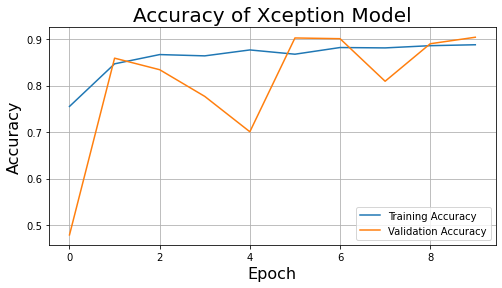

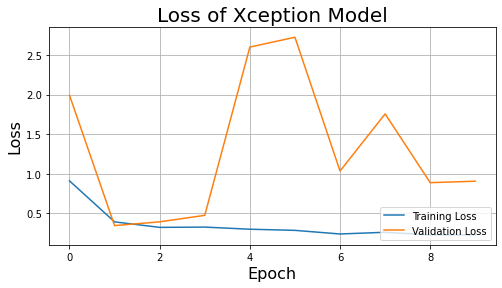

81/81 [==============================] - 16s 197ms/step - loss: 1.0023 - accuracy: 0.8886
Final Loss in Testing: 0.9069202542304993, Final Accuracy in Testing: 90.39%
Final Loss in Training: 1.002278447151184, Final Accuracy in Training: 88.86%


In [88]:
mtr=["Accuracy","Loss"]
for i in mtr:
  plt.figure(figsize=(8,4))
  plt.title("{} of Xception Model".format(i),fontsize=20)
  plt.plot(xcpmodelhist2.history['{}'.format(i.lower())],label="Training {}".format(i))
  plt.plot(xcpmodelhist2.history['{}'.format("val_"+i.lower())],label="Validation {}".format(i))
  plt.xlabel("Epoch",fontsize=16)
  plt.ylabel("{}".format(i),fontsize=16)
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
xcploss2, xcpacc2 = xcpmodel2.evaluate(X_val2, Y_val2)
xcploss2T, xcpacc2T = xcpmodel2.evaluate(X_train2, Y_train2)
print('Final Loss in Testing: {}, Final Accuracy in Testing: {}%'.format(xcploss2, round(xcpacc2,4)*100))
print('Final Loss in Training: {}, Final Accuracy in Training: {}%'.format(xcploss2T, round(xcpacc2T,4)*100))
perfd2[0].append(round(xcpacc2,4)*100)
perfd2[1].append(round(xcpacc2T,4)*100)
perfd2[2].append(round(xcploss2,3))
perfd2[3].append(round(xcploss2T,3))

In [80]:
densemodel2.save('densemodel_2.h5')
vggmodel2.save('vggmodel_2.h5')
xcpmodel2.save('xcpmodel_2.h5')

In [89]:
plantdf1=pd.DataFrame({
    "Model":["DenseNet121","VGG16","Xception"],
    "Test Accuracy":perfd1[0],
    "Training Accuracy":perfd1[1],
    "Test Loss":perfd1[2],
    "Train Loss":perfd1[3]
})
plantdf2=pd.DataFrame({
    "Model":["DenseNet121","VGG16","Xception"],
    "Test Accuracy":perfd2[0],
    "Training Accuracy":perfd2[1],
    "Test Loss":perfd2[2],
    "Train Loss":perfd2[3]
})

In [90]:
plantdf1

,Model,Test Accuracy,Training Accuracy,Test Loss,Train Loss
0,DenseNet121,95.16,94.96,0.202,0.196
1,VGG16,62.40,60.50,1.207,1.240
2,Xception,95.98,96.83,0.166,0.127


In [91]:
plantdf2

,Model,Test Accuracy,Training Accuracy,Test Loss,Train Loss
0,DenseNet121,70.54,66.38,1.163000e+00,1.308000e+00
1,VGG16,45.58,45.96,2.274272e+07,2.320736e+07
2,Xception,90.39,88.86,9.070000e-01,1.002000e+00


In [96]:
for i in plantdf1.columns.tolist()[1:]:
    fig=px.bar(plantdf1,x="Model",y=i,color="Model",text=i,title="{} Comparison (Plant Database-1)".format(i),width=600,height=400)
    fig.update_traces(texttemplate='%{text:.2}%', textposition='inside')
    fig.show()

In [97]:
for i in plantdf2.columns.tolist()[1:]:
    fig=px.bar(plantdf2,x="Model",y=i,color="Model",text=i,title="{} Comparison (Plant Database-2)".format(i),width=600,height=400)
    fig.update_traces(texttemplate='%{text:.2}%', textposition='inside')
    fig.show()